In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.12.0


In [2]:
model = Sequential()
model.add(Conv2D(20,(5,5), padding="same",input_shape=(24,24,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
# sigmoid classifier
model.add(Dense(2))
model.add(Activation("sigmoid"))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 20)        1520      
                                                                 
 activation (Activation)     (None, 24, 24, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 20)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 500)               1440500   
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                        

In [4]:
# create CNN Model
class LeNet:

    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(100, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # sigmoid classifier
        model.add(Dense(classes))
        model.add(Activation("sigmoid"))

        # return the constructed network architecture
        return model


In [5]:
DATASET = "Training"  # this folde must contain three subfolder with images
MODEL = "helmet.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [6]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.chdir("/content/drive/MyDrive/Helmet detection/Helmet Detection")

In [9]:
!dir

flagged  Testing  Training


In [10]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(DATASET)))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Helmet":
            label = 0
        elif label == "No Helmet":
            label = 1

        labels.append(label)
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/582 [00:00<?, ?it/s]

In [11]:
data[0]

array([[[229., 175., 114.],
        [231., 184., 122.],
        [230., 186., 126.],
        ...,
        [240., 229., 225.],
        [236., 205., 166.],
        [243., 210., 165.]],

       [[225., 183., 137.],
        [226., 186., 139.],
        [228., 182., 120.],
        ...,
        [239., 227., 227.],
        [236., 202., 156.],
        [240., 228., 224.]],

       [[227., 176., 113.],
        [231., 178., 115.],
        [230., 181., 119.],
        ...,
        [240., 227., 229.],
        [233., 201., 158.],
        [242., 228., 229.]],

       ...,

       [[195., 123.,  83.],
        [197., 126.,  86.],
        [209., 139., 100.],
        ...,
        [220., 148.,  96.],
        [224., 154., 100.],
        [217., 148.,  91.]],

       [[193., 123.,  83.],
        [194., 125.,  85.],
        [193., 124.,  84.],
        ...,
        [243., 198., 166.],
        [220., 148.,  96.],
        [221., 152., 102.]],

       [[192., 125.,  86.],
        [198., 131.,  86.],
        [198., 1

In [12]:
data[0].shape

(28, 28, 3)

In [13]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [14]:
labels

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,

In [15]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [16]:

trainX.shape

(436, 28, 28, 3)

In [17]:
trainY.shape

(436,)

In [18]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [19]:
trainY[0]

array([1., 0.], dtype=float32)

In [20]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [21]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=2)


opt = Adam(lr=INIT_LR)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

[INFO] compiling model...
[INFO] model complied...


In [22]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        1520      
                                                                 
 activation_3 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_4 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

In [23]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [24]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=200,
              verbose=1)

[INFO] training network...
Epoch 1/200
13/13 [==============================] - 2s 157ms/step - loss: 0.6242 - accuracy: 0.6584 - val_loss: 0.5989 - val_accuracy: 0.6986
Epoch 2/200
13/13 [==============================] - 2s 161ms/step - loss: 0.4818 - accuracy: 0.7572 - val_loss: 0.3742 - val_accuracy: 0.8630
Epoch 3/200
13/13 [==============================] - 2s 179ms/step - loss: 0.3809 - accuracy: 0.8416 - val_loss: 0.3230 - val_accuracy: 0.8425
Epoch 4/200
13/13 [==============================] - 3s 199ms/step - loss: 0.3508 - accuracy: 0.8713 - val_loss: 0.2505 - val_accuracy: 0.9041
Epoch 5/200
13/13 [==============================] - 2s 145ms/step - loss: 0.3919 - accuracy: 0.8534 - val_loss: 0.2457 - val_accuracy: 0.9178
Epoch 6/200
13/13 [==============================] - 2s 145ms/step - loss: 0.3608 - accuracy: 0.8564 - val_loss: 0.2499 - val_accuracy: 0.9247
Epoch 7/200
13/13 [==============================] - 3s 238ms/step - loss: 0.3391 - accuracy: 0.8465 - val_loss: 0.

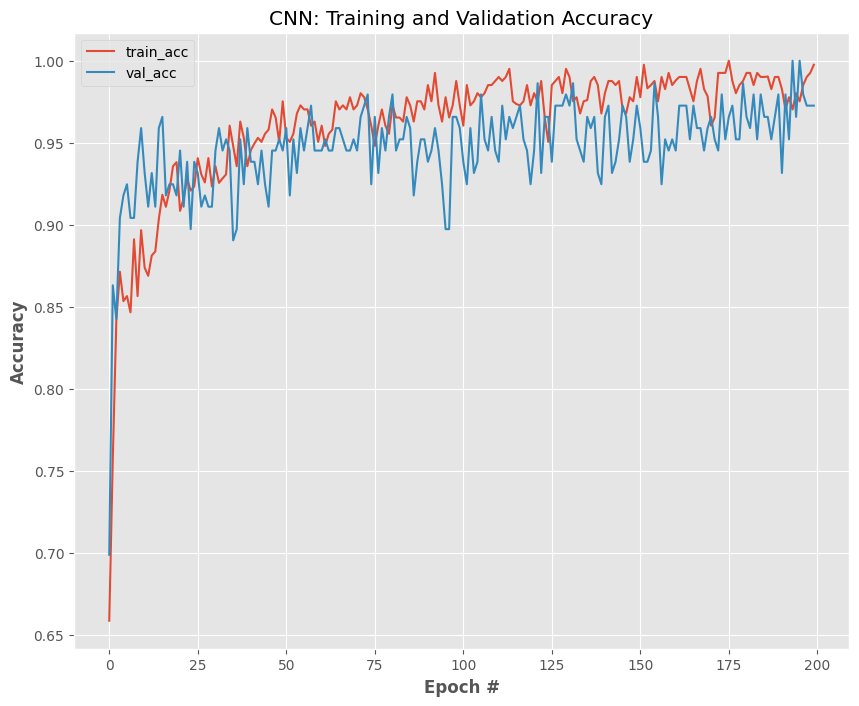

In [39]:
 # plot the training and validation accuracy
N = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

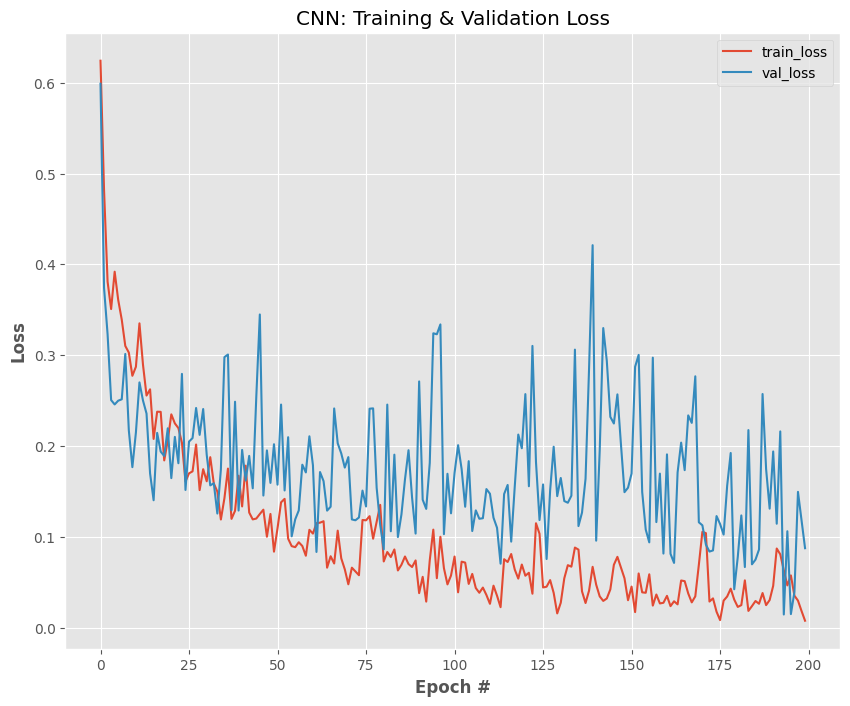

In [26]:
# plot the training and validation loss
N = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [28]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    #plt.grid(b=None)
    ax = fig.add_subplot(111)

    ax.imshow(img)


In [29]:
!dir


flagged  Testing  Training


In [30]:
from tqdm import tqdm

In [31]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('Testing')))   # data folder with 2 categorical folders

all_class = ["Helmet", "No Helmet"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


Output hidden; open in https://colab.research.google.com to view.

In [32]:
!pip install gradio

In [33]:
import gradio as gr

In [34]:
!pip install gradio


In [35]:
def predict_image(image):
    # load the image

    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)


    preds = model.predict(image)[0]
    result = dict()
    result["Helmet"] = round(float(list(preds)[0]), 2)
    result["No Helmet"] = round(float(list(preds)[1]), 2)


    print(result)

    return result

In [36]:
im = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="CNN Demo").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://99a5ed6a50aa63f440.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [37]:
testImagePaths

['Testing/001_beebcee2.jpg',
 'Testing/001_cb004eea.jpg',
 'Testing/002_078f6fe5.jpg',
 'Testing/002_ea6e259d.jpg',
 'Testing/003_936c5a43.jpg',
 'Testing/003_b416eed5.jpg',
 'Testing/004_af9b4c7c.jpg',
 'Testing/004_bb16ac65.jpg',
 'Testing/005_1fc7405f.jpg',
 'Testing/005_37066c18.jpg',
 'Testing/006_07bd8618.jpg',
 'Testing/006_bbb6978e.jpg',
 'Testing/007_9656ae64.jpg',
 'Testing/007_c72ff5ba.jpg',
 'Testing/008_10846cce.jpg',
 'Testing/008_cdaf39e7.jpg',
 'Testing/009_a023db5b.jpg',
 'Testing/009_fc574624.jpg',
 'Testing/010_4eb6eabe.jpg',
 'Testing/011_0dda409c.jpg',
 'Testing/011_0e0e8b1c.jpg',
 'Testing/011_32193038.jpg',
 'Testing/012_19e90fb6.jpg',
 'Testing/012_900c5b05.jpg',
 'Testing/012_be8f222c.jpg',
 'Testing/013_125e020a.jpg',
 'Testing/013_19a43131.jpg',
 'Testing/013_712a38d6.jpg',
 'Testing/014_50bc41b8.jpg',
 'Testing/014_d5c7b58f.jpg',
 'Testing/014_f512d81c.jpg',
 'Testing/015_8adbc3ae.jpg',
 'Testing/015_8da65114.jpg',
 'Testing/015_bca34e2c.jpg',
 'Testing/016_

In [40]:
import cv2
import numpy as np

def predict_image(image):
    # Your pre-processing code here (assuming you have defined the 'model' variable)

    # Pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    result = dict()
    result["Helmet"] = round(float(preds[0]), 2)
    result["No Helmet"] = round(float(preds[1]), 2)

    return result

# Assuming you have a list of image paths named 'testImagePaths'
total_bikers = len(testImagePaths)
total_bikers_with_helmet = 0
total_bikers_without_helmet = 0

for image_path in testImagePaths:
    image = cv2.imread(image_path)
    result = predict_image(image)
    total_bikers_with_helmet += result["Helmet"] > 0.5
    total_bikers_without_helmet += result["No Helmet"] > 0.5

print("Total Bikers:", total_bikers)
print("Bikers with Helmet:", total_bikers_with_helmet)
print("Bikers without Helmet:", total_bikers_without_helmet)


1/1 [==============================] - 0s 21ms/step
Total Bikers: 125
Bikers with Helmet: 11
Bikers without Helmet: 114
